In [1]:
from datasets import load_dataset

# Load the XSum dataset
dataset = load_dataset("EdinburghNLP/xsum")

# Check available splits
print(dataset)

# Preview one example
print(dataset["train"][0])


c:\Users\ga.aldaej\AppData\Local\anaconda3\envs\task9\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 204045
    })
    validation: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 11332
    })
    test: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 11334
    })
})
{'document': 'The full cost of damage in Newton Stewart, one of the areas worst affected, is still being assessed.\nRepair work is ongoing in Hawick and many roads in Peeblesshire remain badly affected by standing water.\nTrains on the west coast mainline face disruption due to damage at the Lamington Viaduct.\nMany businesses and householders were affected by flooding in Newton Stewart after the River Cree overflowed into the town.\nFirst Minister Nicola Sturgeon visited the area to inspect the damage.\nThe waters breached a retaining wall, flooding many commercial properties on Victoria Street - the main shopping thoroughfare.\nJeanette Tate, who owns the Cinnamon 

In [2]:
for split in dataset.keys():
    print(split, len(dataset[split]))


train 204045
validation 11332
test 11334


           doc_len      sum_len
count  2000.000000  2000.000000
mean    375.377500    21.149000
std     286.650425     5.228524
min      11.000000     1.000000
25%     180.000000    18.000000
50%     299.500000    21.000000
75%     495.000000    24.000000
max    2694.000000    55.000000


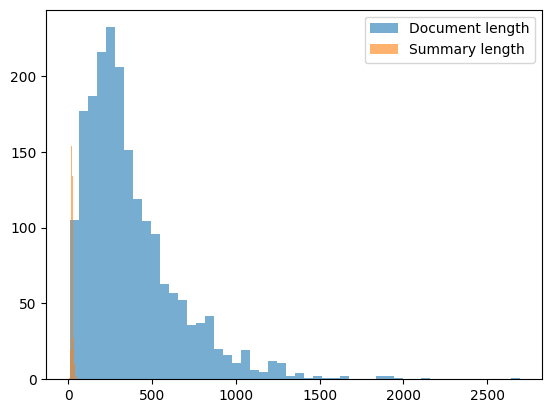

In [3]:
import pandas as pd

sample = dataset["train"].select(range(2000))

doc_lens = [len(x.split()) for x in sample["document"]]
sum_lens = [len(x.split()) for x in sample["summary"]]

df = pd.DataFrame({"doc_len": doc_lens, "sum_len": sum_lens})
print(df.describe())

import matplotlib.pyplot as plt
plt.hist(doc_lens, bins=50, alpha=0.6, label="Document length")
plt.hist(sum_lens, bins=50, alpha=0.6, label="Summary length")
plt.legend()
plt.show()


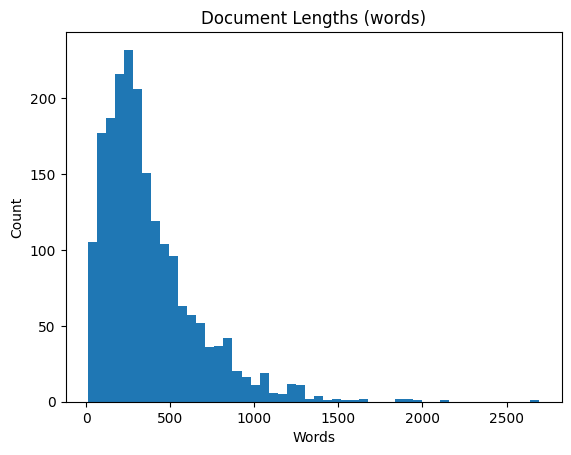

In [8]:
import matplotlib.pyplot as plt
plt.figure()
plt.hist(df["doc_len"], bins=50)
plt.title("Document Lengths (words)")
plt.xlabel("Words")
plt.ylabel("Count")
plt.show()


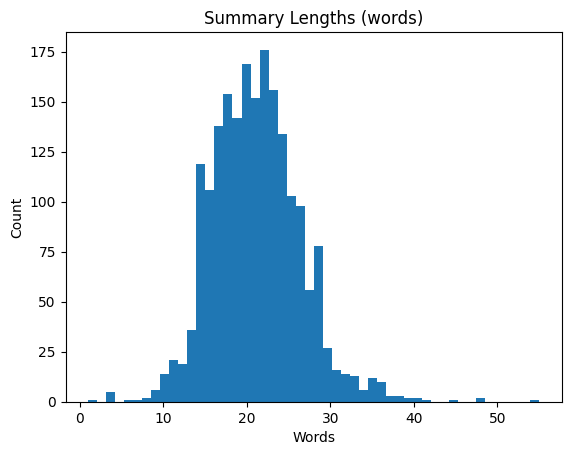

In [9]:
import matplotlib.pyplot as plt
plt.figure()
plt.hist(df["sum_len"], bins=50)
plt.title("Summary Lengths (words)")
plt.xlabel("Words")
plt.ylabel("Count")
plt.show()


In [7]:
for i in range(3):
    print("DOCUMENT:", dataset["train"][i]["document"][:300], "...")
    print("SUMMARY:", dataset["train"][i]["summary"])
    print("-"*80)


DOCUMENT: The full cost of damage in Newton Stewart, one of the areas worst affected, is still being assessed.
Repair work is ongoing in Hawick and many roads in Peeblesshire remain badly affected by standing water.
Trains on the west coast mainline face disruption due to damage at the Lamington Viaduct.
Many ...
SUMMARY: Clean-up operations are continuing across the Scottish Borders and Dumfries and Galloway after flooding caused by Storm Frank.
--------------------------------------------------------------------------------
DOCUMENT: A fire alarm went off at the Holiday Inn in Hope Street at about 04:20 BST on Saturday and guests were asked to leave the hotel.
As they gathered outside they saw the two buses, parked side-by-side in the car park, engulfed by flames.
One of the tour groups is from Germany, the other from China and  ...
SUMMARY: Two tourist buses have been destroyed by fire in a suspected arson attack in Belfast city centre.
----------------------------------------------

In [ ]:
import re, html, unicodedata

_CONTROL = re.compile(r"[\u0000-\u001F\u007F-\u009F]")

def clean_text(t: str) -> str:
    # 1) Unescape HTML entities (&amp; -> &)
    t = html.unescape(t)
    # 2) Strip HTML tags
    t = re.sub(r"<[^>]+>", " ", t)
    # 3) Unicode normalize
    t = unicodedata.normalize("NFKC", t)
    # 4) Remove zero-width + control chars
    t = re.sub(r"[\u200B-\u200D\uFEFF]", "", t)
    t = _CONTROL.sub(" ", t)
    # 5) Collapse all whitespace (including newlines) to single spaces
    t = re.sub(r"\s+", " ", t)
    return t.strip()

# Apply cleaning to add clean columns (reversible; keep originals)
def add_clean_columns(batch):
    return {
        "id": batch["id"],
        "document_clean": [clean_text(x) for x in batch["document"]],
        "summary_clean":  [clean_text(x) for x in batch["summary"]],
    }

cleaned = dataset.map(add_clean_columns, batched=True)  
cleaned


DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id', 'document_clean', 'summary_clean'],
        num_rows: 204045
    })
    validation: Dataset({
        features: ['document', 'summary', 'id', 'document_clean', 'summary_clean'],
        num_rows: 11332
    })
    test: Dataset({
        features: ['document', 'summary', 'id', 'document_clean', 'summary_clean'],
        num_rows: 11334
    })
})

In [64]:
import os, pandas as pd
os.makedirs("data", exist_ok=True)
validation = cleaned["validation"]
pd.DataFrame({
    "id": validation["id"],
    "document": validation["document_clean"],
    "summary":  validation["summary_clean"],
}).to_csv("data/preprocessed_dataset.csv", index=False, encoding="utf-8")
print("Saved to data/preprocessed_dataset.csv")


Saved to data/preprocessed_dataset.csv


In [ ]:
from transformers import AutoTokenizer

model_name = "facebook/bart-large-cnn"
tok = AutoTokenizer.from_pretrained(model_name)

MAX_SOURCE = 1024  # BART encoder input length
MAX_TARGET = 64    # XSum summaries are very short (~1 sentence)
print("Tokenizer loaded for:", model_name)


Tokenizer loaded for: facebook/bart-large-cnn


In [8]:
def tokenize_batch(batch):
    enc = tok(
        batch["document_clean"],
        max_length=MAX_SOURCE,
        truncation=True,
        padding="max_length",
    )
    with tok.as_target_tokenizer():
        lab = tok(
            batch["summary_clean"],
            max_length=MAX_TARGET,
            truncation=True,
            padding="max_length",
        )
    enc["labels"] = lab["input_ids"]
    enc["id"] = batch["id"]
    return enc

# Remove original columns to keep token IDs only
cols_to_remove = list(set(dataset["train"].column_names + ["document_clean", "summary_clean"]))
tokenized = cleaned.map(tokenize_batch, batched=True, remove_columns=cols_to_remove)
tokenized


Map:   0%|          | 0/204045 [00:00<?, ? examples/s]c:\Users\ga.aldaej\AppData\Local\anaconda3\envs\task9\lib\site-packages\transformers\tokenization_utils_base.py:4006: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
Map: 100%|██████████| 11334/11334 [00:14<00:00, 786.03 examples/s]


DatasetDict({
    train: Dataset({
        features: ['id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 204045
    })
    validation: Dataset({
        features: ['id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 11332
    })
    test: Dataset({
        features: ['id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 11334
    })
})

In [9]:
import os
os.makedirs("data", exist_ok=True)
tokenized.save_to_disk("data/xsum_tokenized_bart")
print("Saved tokenized dataset to data/xsum_tokenized_bart")


Saving the dataset (0/3 shards):   0%|          | 0/204045 [00:00<?, ? examples/s]

Saving the dataset (1/1 shards): 100%|██████████| 11334/11334 [00:00<00:00, 266616.42 examples/s]

Saved tokenized dataset to data/xsum_tokenized_bart


In [ ]:
ex = tokenized["train"][0]
print(len(ex["input_ids"]), len(ex["labels"]))  # should be 1024 and 64
print(ex.keys())


1024 64
dict_keys(['id', 'input_ids', 'attention_mask', 'labels'])


In [11]:
print(tok.decode(ex["input_ids"][:80]))


<s>The full cost of damage in Newton Stewart, one of the areas worst affected, is still being assessed. Repair work is ongoing in Hawick and many roads in Peeblesshire remain badly affected by standing water. Trains on the west coast mainline face disruption due to damage at the Lamington Viaduct. Many businesses and householders were affected by flooding in Newton Stewart after the


In [ ]:
import torch

HAS_GPU = torch.cuda.is_available()

VAL_TOTAL = len(cleaned["validation"])        
N = VAL_TOTAL if HAS_GPU else 200             

val_small = cleaned["validation"].select(range(N))
texts = val_small["document_clean"]           # inputs for summarization
refs  = val_small["summary_clean"]            # ground truth summaries for ROUGE

print(f"GPU available: {HAS_GPU}")
print(f"Validation total: {VAL_TOTAL} | Using N={N}")
print("Sample doc preview:", texts[0][:120], "...")
print("Sample ref:", refs[0])


GPU available: True
Validation total: 11332 | Using N=11332
Sample doc preview: The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise m ...
Sample ref: Former Premier League footballer Sam Sodje has appeared in court alongside three brothers accused of charity fraud.


In [ ]:
# Extractive: SBERT TextRank (unsupervised, 1 sentence) 
import os, json, re, math, numpy as np
from tqdm.auto import tqdm
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer as SumyTokenizer
from sentence_transformers import SentenceTransformer

# ---- Settings / outputs ----
os.makedirs("outputs", exist_ok=True)
SAVE_JSONL = "outputs/sbert_textrank_preds_val.jsonl"
SAVE_JSON  = "outputs/sbert_textrank_preds_val.json"

MODEL_NAME = "all-MiniLM-L6-v2"   # small, fast, good quality
DAMPING = 0.85                    # PageRank damping
TOPK_TIE = 3                      # take earliest among top-k ranked (tiny position prior)
MIN_WORDS, MAX_WORDS = 6, 60      # length filter for nicer sentences

# Helpers functions 
def _first_sentence(text: str) -> str:
    text = (text or "").strip()
    if not text: return ""
    s = re.split(r'(?<=[.!?])\s+', text)[0]
    return s if re.search(r'[.!?]$', s) else s + "."

def _split_sents(text: str):
    parser = PlaintextParser.from_string(text or "", SumyTokenizer("english"))
    return [str(s).strip() for s in parser.document.sentences]

def _ok_len(s: str) -> bool:
    n = len(re.findall(r"\w+", s))
    return MIN_WORDS <= n <= MAX_WORDS

# PageRank implementation (the core summary algorithm)
def _pagerank(W, d=0.85, tol=1e-6, max_iter=100):
    n = W.shape[0]
    if n == 1:
        return np.array([1.0])
    # zero diag & non-negative
    np.fill_diagonal(W, 0.0)
    W = np.maximum(W, 0.0)

    row_sums = W.sum(axis=1, keepdims=True)
    P = np.divide(W, row_sums, out=np.full_like(W, 1.0/n), where=row_sums>0)

    r = np.full(n, 1.0/n)
    v = np.full(n, 1.0/n)
    for _ in range(max_iter):
        r_new = d * P.T.dot(r) + (1-d) * v
        if np.linalg.norm(r_new - r, 1) < tol:
            return r_new
        r = r_new
    return r

# SBERT model
_embedder = SentenceTransformer(MODEL_NAME, device='cpu')

def sbert_textrank_one_sentence(text: str) -> str:
    sents = _split_sents(text)
    if not sents:
        return _first_sentence(text)
    if len(sents) == 1:
        return _first_sentence(sents[0])

    # Sentence embeddings (unit-normalized for cosine)
    embs = _embedder.encode(sents, normalize_embeddings=True, convert_to_numpy=True)

    # Cosine similarity matrix (>=0, diag=0)
    S = np.clip(embs @ embs.T, 0.0, 1.0)
    np.fill_diagonal(S, 0.0)

    # PageRank centrality
    pr = _pagerank(S, d=DAMPING)

    # Take top-k by PR, prefer reasonable length then earliest position
    idx_sorted = np.argsort(-pr)
    top = idx_sorted[:min(TOPK_TIE, len(sents))]
    # filter by length; if none pass, keep the PR top set
    top_filtered = [i for i in top if _ok_len(sents[i])]
    chosen_idx = min(top_filtered) if top_filtered else min(top)
    out = sents[chosen_idx].strip()
    return out if re.search(r'[.!?]$', out) else out + "."

# Run with resume
extractive_preds = []
start = 0
if os.path.exists(SAVE_JSONL):
    with open(SAVE_JSONL, "r", encoding="utf-8") as f:
        for line in f:
            try:
                extractive_preds.append(json.loads(line)["pred"])
            except:
                pass
    start = len(extractive_preds)
if start > 0:
    print(f"Resuming from {start}/{len(texts)}")

with open(SAVE_JSONL, "a", encoding="utf-8") as fout:
    for i in tqdm(range(start, len(texts)), desc="SBERT TextRank (extractive)"):
        pred = sbert_textrank_one_sentence(texts[i])
        extractive_preds.append(pred)
        fout.write(json.dumps({"pred": pred}, ensure_ascii=False) + "\n")

with open(SAVE_JSON, "w", encoding="utf-8") as f:
    json.dump(extractive_preds, f, ensure_ascii=False, indent=2)

print("Saved:", SAVE_JSONL, "and", SAVE_JSON)
print("Total preds:", len(extractive_preds))


SBERT TextRank (extractive): 100%|██████████| 11332/11332 [18:07<00:00, 10.42it/s]

Saved: outputs/sbert_textrank_preds_val.jsonl and outputs/sbert_textrank_preds_val.json
Total preds: 11332


In [27]:
import re, torch
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM

DEV = 0 if torch.cuda.is_available() else -1
model_name = "google/flan-t5-base"   # <— instruction-tuned

tok = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

flan = pipeline("text2text-generation", model=model, tokenizer=tok, device=DEV)

def to_one_sentence(s: str) -> str:
    s = s.strip()
    s = re.split(r"(?<=[.!?])\s+", s)[0] if s else s
    s = s.strip(" .")
    if s and not s[0].isupper(): s = s[0].upper() + s[1:]
    if s and s[-1] not in ".!?": s += "."
    return s

PROMPT = (
    "Summarize the document in ONE factual sentence, capturing WHO, WHAT happened, and WHEN if present. "
    "Avoid stats and side details. Use only facts from the article.\n\nArticle:\n"
)

GEN = dict(
    max_new_tokens=26, min_length=10,
    do_sample=False, num_beams=5, length_penalty=1.05,
    no_repeat_ngram_size=3, early_stopping=True
)

def flan_summarize(doc: str) -> str:
    out = flan(PROMPT + doc, **GEN)[0]["generated_text"]
    return to_one_sentence(out)

# demo
for i in range(2):
    print(f"\n== FLAN-T5 Example {i} ==")
    print("REF:", refs[i])
    print("OUT:", flan_summarize(texts[i]))



== FLAN-T5 Example 0 ==
REF: Former Premier League footballer Sam Sodje has appeared in court alongside three brothers accused of charity fraud.
OUT: Former Reading defender Sam Sodje has appeared in court charged with fraud.

== FLAN-T5 Example 1 ==
REF: Middlesex batsman Adam Voges will be out until August after suffering a torn calf muscle in his right leg.
OUT: Middlesex's Adam Voges has been ruled out for the remainder of the season with a hamstring injury.


In [ ]:
import re, torch
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM

DEV = 0 if torch.cuda.is_available() else -1
name = "google/flan-t5-base"
tok = AutoTokenizer.from_pretrained(name)
model = AutoModelForSeq2SeqLM.from_pretrained(name)
flan = pipeline("text2text-generation", model=model, tokenizer=tok, device=DEV)



FEWSHOT = (
    "You are a summary assistant. Provide a summary of the following document highlighting the key themes and arguments. Summarize using ONLY facts from Document.\n"
    "Write ONE concise factual sentence capturing WHO, WHAT happened, and WHEN mentioning the reasons if present .\n"
    "DOCUMENT:\n"
    '''Administrators confirmed the redundancies affecting 38 staff at Galashiels-based Murray and Burrell.
        The business, established in 1928, went into administration last week citing "adverse trading conditions".
        There are hopes some of the workers affected could find posts at another building firm in nearby Melrose which currently requires staff.
        Thomson Cooper partner Richard Gardiner was appointed as administrator at Murray and Burrell on Monday.
        A statement confirmed: "Directors explored all options in an effort to preserve trading and jobs.
        "Regrettably, 38 jobs were lost as there is no prospect of continuing to trade."
        South of Scotland MSP Rachael Hamilton described it as a "sad day for the Borders".
        However, some of the workers laid off could find employment with a Melrose-based company.
        JS Crawford has said that, with several housing projects on its books, it needs staff.\n'''
    "SUMMARY:\n"
    "Dozens of jobs have been lost after efforts to save an historic building firm in the Scottish Borders failed.\n\n"

    "Another example, DOCUMENT:\n"
        '''Wood sustained the injury whilst bowling against Middlesex in the County Championship on 4 May.
        "It is a blow to us, he has been influential in our one-day cricket and we will miss him," Hampshire's director of cricket Giles White told BBC Radio Solent.
        The 25-year-old left-arm seamer underwent surgery last week.
        Wood is the latest Hampshire bowler to succumb to long-term injury this season, with Fidel Edwards, Reece Topley and Gareth Berg all currently sidelined.
        Topley was injured on his Hampshire debut against Warwickshire in April.
        Hampshire recently signed Tino Best, Craig Young and ex-Worcestershire seamer Gareth Andrew on a match-by-match basis to alleviate their injury concerns.\n'''
    "SUMMARY:\n"
    "Hampshire bowler Chris Wood has been ruled out for the rest of the season with a knee injury.\n\n"

)

def flan_strict(doc: str) -> str:
    prompt = FEWSHOT + "DOCUMENT:\n" + doc + "\nSUMMARY:\n"
    out = flan(
        prompt,
        max_new_tokens=45, min_length=10,
        do_sample=False, num_beams=6, length_penalty=1.05,
        no_repeat_ngram_size=3, early_stopping=True
    )[0]["generated_text"]
    return out

# quick demo on your two examples
for i in range(texts):
    print(f"\n== FLAN strict (few-shot) Example {i} ==")
    print("REF:", refs[i])
    print("OUT:", flan_strict(texts[i]))




== FLAN strict (few-shot) Example 0 ==
REF: Former Premier League footballer Sam Sodje has appeared in court alongside three brothers accused of charity fraud.
OUT: Former Reading defender Sam Sodje has appeared in court charged with fraud.

== FLAN strict (few-shot) Example 1 ==
REF: Middlesex batsman Adam Voges will be out until August after suffering a torn calf muscle in his right leg.
OUT: Middlesex's Adam Voges has been ruled out for the rest of the season with a hamstring injury.

== FLAN strict (few-shot) Example 2 ==
REF: The Duchess of Cambridge will feature on the cover of British Vogue to mark the magazine's centenary.
OUT: The Duchess of Cambridge is to feature in British Vogue's 100th issue for the first time.

== FLAN strict (few-shot) Example 3 ==
REF: Google has hired the creator of one of the web's most notorious forums - 4chan.
OUT: Google has appointed a former administrator of the controversial 4chan website as its new chief executive.

== FLAN strict (few-shot) E

In [ ]:
# Abstractive: flan-t5 few-shot (prompt) 
import os, json, warnings, torch
from tqdm.auto import tqdm
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM
from transformers.utils import logging as hf_logging

# Quiet HF warnings 
hf_logging.set_verbosity_error()
warnings.filterwarnings("ignore", message=r"Both `max_new_tokens`.*")
warnings.filterwarnings("ignore", message=r"Your max_length is set to .*")

# Device & pipeline
DEV = 0 if torch.cuda.is_available() else -1
print("Device set to:", "cuda:0" if DEV == 0 else "cpu")

name = "google/flan-t5-base"
tok = AutoTokenizer.from_pretrained(name)
model = AutoModelForSeq2SeqLM.from_pretrained(name)
flan = pipeline("text2text-generation", model=model, tokenizer=tok, device=DEV)

# FEWSHOT prompt 
FEWSHOT = (
    "You are a summary assistant. Provide a summary of the following document highlighting the key themes and arguments. "
    "Summarize using ONLY facts from Document.\n"
    "Write ONE concise factual sentence capturing WHO, WHAT happened, and WHEN mentioning the reasons if present .\n"
    "DOCUMENT:\n"
    '''Administrators confirmed the redundancies affecting 38 staff at Galashiels-based Murray and Burrell.
        The business, established in 1928, went into administration last week citing "adverse trading conditions".
        There are hopes some of the workers affected could find posts at another building firm in nearby Melrose which currently requires staff.
        Thomson Cooper partner Richard Gardiner was appointed as administrator at Murray and Burrell on Monday.
        A statement confirmed: "Directors explored all options in an effort to preserve trading and jobs.
        "Regrettably, 38 jobs were lost as there is no prospect of continuing to trade."
        South of Scotland MSP Rachael Hamilton described it as a "sad day for the Borders".
        However, some of the workers laid off could find employment with a Melrose-based company.
        JS Crawford has said that, with several housing projects on its books, it needs staff.\n'''
    "SUMMARY:\n"
    "Dozens of jobs have been lost after efforts to save an historic building firm in the Scottish Borders failed.\n\n"

    "Another example, DOCUMENT:\n"
        '''Wood sustained the injury whilst bowling against Middlesex in the County Championship on 4 May.
        "It is a blow to us, he has been influential in our one-day cricket and we will miss him," Hampshire's director of cricket Giles White told BBC Radio Solent.
        The 25-year-old left-arm seamer underwent surgery last week.
        Wood is the latest Hampshire bowler to succumb to long-term injury this season, with Fidel Edwards, Reece Topley and Gareth Berg all currently sidelined.
        Topley was injured on his Hampshire debut against Warwickshire in April.
        Hampshire recently signed Tino Best, Craig Young and ex-Worcestershire seamer Gareth Andrew on a match-by-match basis to alleviate their injury concerns.\n'''
    "SUMMARY:\n"
    "Hampshire bowler Chris Wood has been ruled out for the rest of the season with a knee injury.\n\n"
)

# generation function 
def flan_strict(doc: str) -> str:
    prompt = FEWSHOT + "DOCUMENT:\n" + doc + "\nSUMMARY:\n"
    out = flan(
        prompt,
        max_new_tokens=45, min_length=10,
        do_sample=False, num_beams=6, length_penalty=1.05,
        no_repeat_ngram_size=3, early_stopping=True
    )[0]["generated_text"]
    return out

# Run over the whole validation set with resume + progress 
os.makedirs("outputs", exist_ok=True)
SAVE_JSONL = "outputs/flan_preds_val_STRICT.jsonl"  # separate filename to avoid mixing
SAVE_JSON  = "outputs/flan_preds_val_STRICT.json"

preds = []
start = 0
if os.path.exists(SAVE_JSONL):
    with open(SAVE_JSONL, "r", encoding="utf-8") as f:
        for line in f:
            try:
                preds.append(json.loads(line)["pred"])
            except Exception:
                pass
    start = len(preds)
if start > 0:
    print(f"Resuming from {start}/{len(texts)}")

with open(SAVE_JSONL, "a", encoding="utf-8") as fout:
    for i in tqdm(range(start, len(texts)), desc="FLAN strict (few-shot)"):
        pred = flan_strict(texts[i])  # <- identical single-string call pattern
        preds.append(pred)
        fout.write(json.dumps({"pred": pred}, ensure_ascii=False) + "\n")

with open(SAVE_JSON, "w", encoding="utf-8") as f:
    json.dump(preds, f, ensure_ascii=False, indent=2)

print("Finished. Total preds:", len(preds))
print("Sample:", preds[:3])


Device set to: cuda:0


FLAN strict (few-shot): 100%|██████████| 11332/11332 [2:33:04<00:00,  1.23it/s]  

Finished. Total preds: 11332
Sample: ['Former Reading defender Sam Sodje has appeared in court charged with fraud.', "Middlesex's Adam Voges has been ruled out for the rest of the season with a hamstring injury.", "The Duchess of Cambridge is to feature in British Vogue's 100th issue for the first time."]


In [48]:
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rouge_score import rouge_scorer

def load_preds(json_path, jsonl_path, key="pred"):
    if os.path.exists(json_path):
        with open(json_path, "r", encoding="utf-8") as f:
            return json.load(f)
    with open(jsonl_path, "r", encoding="utf-8") as f:
        return [json.loads(line)[key] for line in f]

# 1) Extractive 
extractive = load_preds(
    "outputs/textrank_preds_val.json",
    "outputs/textrank_preds_val.jsonl"
)

# 2) Abstractive 
abstractive = load_preds(
        "outputs/flan_preds_val_STRICT.json",
        "outputs/flan_preds_val_STRICT.jsonl"
    )


# Align with dataset
N = min(len(texts), len(refs), len(extractive), len(abstractive))
texts_, refs_, ext_, abs_ = texts[:N], refs[:N], extractive[:N], abstractive[:N]
print(f"Evaluating on N={N}")



Evaluating on N=11332


In [51]:
scorer = rouge_scorer.RougeScorer(["rouge1","rouge2","rougeL"], use_stemmer=True)

def avg_rouge(preds, refs):
    r1=r2=rL=0.0
    for p, r in zip(preds, refs):
        s = scorer.score(r, p)
        r1 += s["rouge1"].fmeasure
        r2 += s["rouge2"].fmeasure
        rL += s["rougeL"].fmeasure
    m = len(refs)
    return {"ROUGE-1": r1/m, "ROUGE-2": r2/m, "ROUGE-L": rL/m}

scores_ext = avg_rouge(ext_, refs_)
scores_abs = avg_rouge(abs_, refs_)

score_df = pd.DataFrame(
    [scores_ext, scores_abs],
    index=["Extractive (SBERT TextRank)", "Abstractive (FLAN-T5)"]
).round(4)
score_df


,ROUGE-1,ROUGE-2,ROUGE-L
Extractive (SBERT TextRank),0.1834,0.0260,0.1312
Abstractive (FLAN-T5),0.3536,0.1338,0.2803


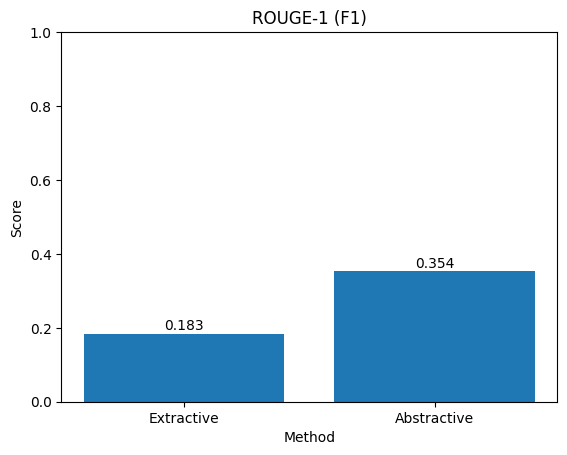

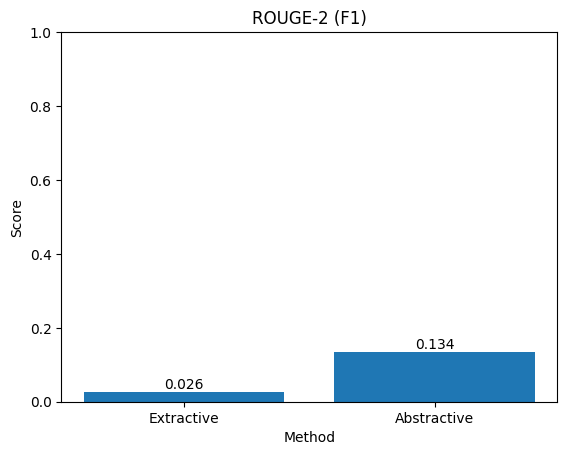

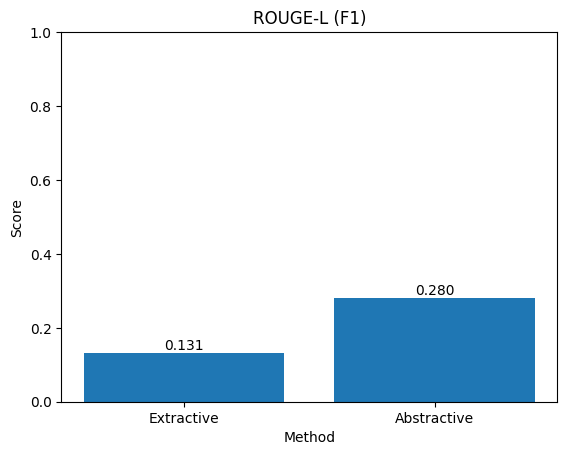

In [54]:
def bar(metric):
    vals = [scores_ext[metric], scores_abs[metric]]
    plt.figure()
    plt.bar(["Extractive", "Abstractive"], vals)
    plt.ylim(0, 1)
    plt.title(f"{metric} (F1)")
    for i, v in enumerate(vals):
        plt.text(i, v + 0.01, f"{v:.3f}", ha="center")
    plt.xlabel("Method"); plt.ylabel("Score")
    plt.show()

bar("ROUGE-1")
bar("ROUGE-2")
bar("ROUGE-L")


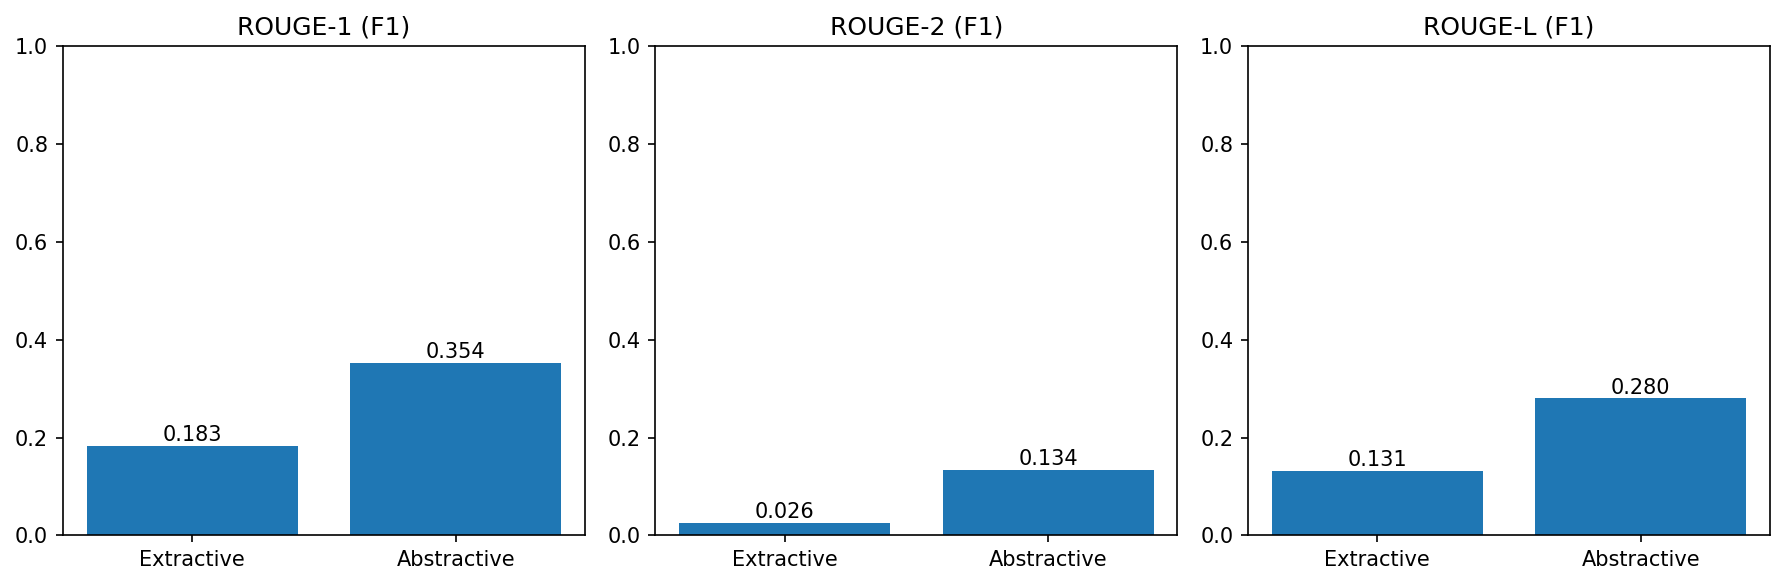

Saved: figures/rouge_scores.png


In [ ]:
# Save ROUGE bars as an image PNG
import os
os.makedirs("figures", exist_ok=True)

metrics = ["ROUGE-1", "ROUGE-2", "ROUGE-L"]
vals_ext = [scores_ext[m] for m in metrics]
vals_abs = [scores_abs[m] for m in metrics]

fig, axes = plt.subplots(1, 3, figsize=(12, 4), dpi=150)
for ax, m, v_e, v_a in zip(axes, metrics, vals_ext, vals_abs):
    ax.bar(["Extractive", "Abstractive"], [v_e, v_a])
    ax.set_title(f"{m} (F1)")
    ax.set_ylim(0, 1)
    for i, v in enumerate([v_e, v_a]):
        ax.text(i, v + 0.01, f"{v:.3f}", ha="center")

fig.tight_layout()
fig.savefig("figures/rouge_scores.png", bbox_inches="tight")
plt.show()
print("Saved: figures/rouge_scores.png")


In [59]:
import pandas as pd

# show full examples in DataFrame cells 
pd.set_option("display.max_colwidth", None)   
pd.set_option("display.width", 0)             

EX_N = 10
rows = []
for i in range(EX_N):
    rows.append({
        "id": i,
        "Input": texts_[i][i:600]+ ("..." if len(texts_[i]) > 600 else ""),  # truncate for display       
        "Reference": refs_[i],
        "Extractive": ext_[i],
        "Abstractive": abs_[i],
    })
examples_df = pd.DataFrame(rows)
examples_df


,id,Input,Reference,Extractive,Abstractive
0,0,"The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian sport. Mr Sodje, 37, is jointly charged with elder brothers Efe, 44, Bright, 50 and Stephen, 42. Appearing at the Old Bailey earlier, all four denied the offence. The charge relates to offences which allegedly took place between 2008 and 2014. Sam, from Kent, Efe and Bright, of Greater Manchester, and Stephen, from Bexley, are due to stand trial in July. They were all released on bail.",Former Premier League footballer Sam Sodje has appeared in court alongside three brothers accused of charity fraud.,The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian sport.,Former Reading defender Sam Sodje has appeared in court charged with fraud.
1,1,"oges was forced to retire hurt on 86 after suffering the injury while batting during the County Championship draw with Somerset on 4 June. Middlesex hope to have the Australian back for their T20 Blast game against Hampshire at Lord's on 3 August. The 37-year-old has scored 230 runs in four first-class games this season at an average of 57.50. ""Losing Adam is naturally a blow as he contributes significantly to everything we do,"" director of cricket Angus Fraser said. ""His absence, however, does give opportunities to other players who are desperate to play in the first XI. ""In the past we have...",Middlesex batsman Adam Voges will be out until August after suffering a torn calf muscle in his right leg.,"Voges retired from international cricket in February with a Test batting average of 61.87 from 31 innings, second only to Australian great Sir Donald Bradman's career average of 99.94 from 52 Tests.",Middlesex's Adam Voges has been ruled out for the rest of the season with a hamstring injury.
2,2,"ven photographs taken in the Norfolk countryside by photographer Josh Olins will appear in the June edition. In her first sitting for a magazine, the duchess is seen looking relaxed and wearing casual clothes. The shoot was in collaboration with the National Portrait Gallery, where two images are being displayed in the Vogue 100: A Century of Style exhibition. The duchess, who has a keen interest in photography, has been patron of the National Portrait Gallery since 2012. Nicholas Cullinan, director of the National Portrait Gallery, said: ""Josh has captured the duchess exactly as she is - fu...",The Duchess of Cambridge will feature on the cover of British Vogue to mark the magazine's centenary.,"He said the images also encapsulated what Vogue had done over the past 100 years - ""to pair the best photographers with the great personalities of the day, in order to reflect broader shifts in culture and society"".",The Duchess of Cambridge is to feature in British Vogue's 100th issue for the first time.
3,3,"is Poole - known as ""moot"" online - created the site in 2003. It has gone on to be closely associated with offensive and often illegal activity, including instances where the images of child abuse were shared. It was widely credited as being the first place where leaked images of nude celebrities were posted following 2014's well-publicised security breach affecting Apple's iCloud service. That incident prompted a policy change on the site. However, 4chan has also been the rallying point for many instances of online activism from the likes of Anonymous, the loosely organized hacktivism grou...",Google has hired the creator of one of the web's most notorious forums - 4chan.,"He added: ""I can't wait to contribute my own experience from a dozen years of building online communities, and to begin the next chapter of my career at such an incredible company.""",Google has appointed a former administrator of the controversial 4chan website as its new chief executive.
4,4,"police officers were injured in the incident on Friday night. A 

In [ ]:
# Save examples as an image PNG
import os, textwrap, matplotlib.pyplot as plt
os.makedirs("figures", exist_ok=True)

def _wrap(s, width):
    s = "" if s is None else str(s)
    return "\n".join(textwrap.wrap(s, width=width, break_long_words=False, replace_whitespace=False)) or " "

# 1) Wrap text for display 
wrap_w = {"Input": 120, "Reference": 70, "Extractive": 70, "Abstractive": 70}
disp = examples_df.copy()
for col, w in wrap_w.items():
    disp[col] = disp[col].apply(lambda x: _wrap(x, w))

# 2) Figure size scales with total number of wrapped lines (better than rows)
def _line_count(s): return (s.count("\n") + 1) if isinstance(s, str) else 1
body_max_lines = [max(_line_count(v) for v in disp.iloc[i, :]) for i in range(len(disp))]
header_lines = 1

total_lines = header_lines + sum(body_max_lines)
fig_w = 24
fig_h = max(4.0, 0.40 * total_lines)   # increase 0.40 if you want more vertical space

fig, ax = plt.subplots(figsize=(fig_w, fig_h), dpi=160)
ax.axis("off")

# 3) Column widths (must sum ~1.0)
col_widths = [0.04, 0.46, 0.17, 0.17, 0.16]  # id, Input, Ref, Extr, Abstr

tbl = ax.table(
    cellText=disp.values,
    colLabels=disp.columns,
    colWidths=col_widths,
    loc="upper left",
    cellLoc="left",
)

# 4) Styling
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)   # change if needed

# 5) Auto-fit row heights
all_lines = [header_lines] + body_max_lines               # include header row at index 0
sum_lines = float(sum(all_lines))
row_heights = [ln / sum_lines for ln in all_lines]        

n_rows, n_cols = disp.shape
for r in range(n_rows + 1):            # +1 for header
    h = row_heights[r]
    for c in range(n_cols):
        cell = tbl[(r, c)]
        cell.set_height(h)
        cell.set_edgecolor("#666")
        cell.set_linewidth(0.6)
        if r == 0:
            cell.set_text_props(weight="bold")

fig.tight_layout()
out_path = "figures/summary_examples.png"
fig.savefig(out_path, bbox_inches="tight")
plt.close(fig)
print("Saved:", out_path)


Saved: figures/summary_examples.png
